### Growth Rate Modeling 

Fit an exponential growth model to chips/chambers with automatically identified cell counts and summarize the distribution of those inferred growth rates.

### Data Prep

In [12]:
library(tidyverse)
library(magrittr)
library(reshape2)

# Load counts of cells on chips from CV model
df <- read_csv('/Users/eczech/Google Drive/data/celldom/results/201805/v1/chip_data.csv')

# Add "chip_name" to identify st + apt combinations
df %<>% mutate(chip_name = paste(
  paste('st', image_meta_stnum, sep='='),
  paste('apt', image_meta_aptnum, sep='='),
  sep='|'
))
head(df)

Parsed with column specification:
cols(
  image_path = col_character(),
  image_name = col_character(),
  image_meta_stnum = col_integer(),
  image_meta_day = col_integer(),
  image_meta_aptnum = col_integer(),
  image_id = col_integer(),
  image_group = col_character(),
  chip_trap_count = col_integer(),
  chip_stnum_count = col_integer(),
  chip_marker_count = col_integer(),
  chip_channel_count = col_integer(),
  chip_chamber_count = col_integer(),
  chip_chamber_area = col_integer(),
  chip_cellunion_chamber_pct = col_double(),
  chip_cellclump_chamber_pct = col_double(),
  chip_cell_count_trap = col_integer(),
  chip_cell_count_chamber = col_integer(),
  chip_cell_count = col_integer(),
  chip_aptnum_count = col_integer()
)


image_path,image_name,image_meta_stnum,image_meta_day,image_meta_aptnum,image_id,image_group,chip_trap_count,chip_stnum_count,chip_marker_count,chip_channel_count,chip_chamber_count,chip_chamber_area,chip_cellunion_chamber_pct,chip_cellclump_chamber_pct,chip_cell_count_trap,chip_cell_count_chamber,chip_cell_count,chip_aptnum_count,chip_name
/lab/data/celldom/data/dataset02/BF_ST_003_APT_010Day0.jpg,BF_ST_003_APT_010Day0.jpg,3,0,10,0,external,1,1,1,2,1,26794,0.4814511,0.000000,0,1,1,1,st=3|apt=10
/lab/data/celldom/data/dataset02/BF_ST_007_APT_009Day3.jpg,BF_ST_007_APT_009Day3.jpg,7,3,9,1,external,1,1,1,2,1,27227,0.5215411,0.000000,0,1,1,1,st=7|apt=9
/lab/data/celldom/data/dataset02/BF_ST_000_APT_000Day0.jpg,BF_ST_000_APT_000Day0.jpg,0,0,0,2,training,1,1,1,2,1,27187,0.9784088,1.022548,1,2,3,1,st=0|apt=0
/lab/data/celldom/data/dataset02/BF_ST_000_APT_000Day1.jpg,BF_ST_000_APT_000Day1.jpg,0,1,0,3,training,1,1,1,2,1,27455,5.6528865,6.235658,0,14,14,1,st=0|apt=0
/lab/data/celldom/data/dataset02/BF_ST_000_APT_000Day2.jpg,BF_ST_000_APT_000Day2.jpg,0,2,0,4,training,1,1,1,2,1,27140,16.3227708,15.357406,1,31,32,1,st=0|apt=0
/lab/data/celldom/data/dataset02/BF_ST_000_APT_000Day3.jpg,BF_ST_000_APT_000Day3.jpg,0,3,0,5,training,1,1,1,2,1,27090,44.0310078,42.620893,2,84,86,1,st=0|apt=0


In [27]:
# Remove any chips that had 0 cells at some point and filter only to day 0-3 
# data to avoid dealing to need with saturation (otherwise, fitting exponential
# model makes no sense)
bad.chips <- df %>% filter(chip_cell_count == 0) %>% .$chip_name %>% as.character
df.m <- df %>% 
  filter(image_meta_day <= 3) %>%
  filter(!(chip_name %in% bad.chips))

# Ensure there are now 4 days worth of data for each chip
stopifnot(all(df.m %>% group_by(chip_name) %>% tally() %>% .$n==4))

# Also ensure that all cell counts are nonzero
stopifnot(all(df.m$chip_cell_count > 0))

paste('Num chips before filtering:', length(unique(df$chip_name)))
paste('Num chips after filtering:', length(unique(df.m$chip_name)))

[1] "Num chips before filtering: 171"

[1] "Num chips after filtering: 155"

Quick visualization before modeling:

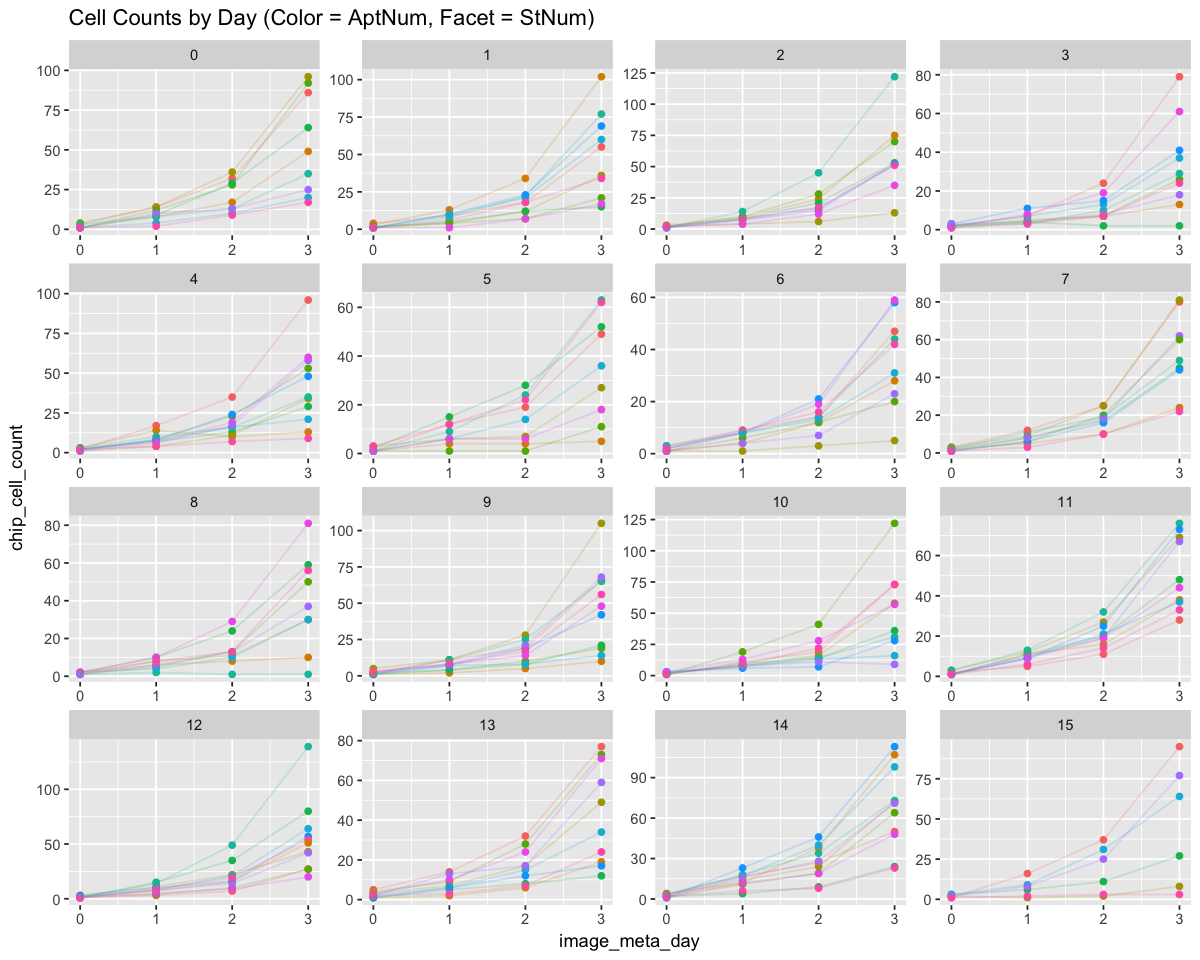

In [30]:
# Plot count and day for each apartment, and group plots by stnum
options(repr.plot.width=10, repr.plot.height=8)
df.m %>% ggplot(aes(x=image_meta_day, y=chip_cell_count, color=as.factor(image_meta_aptnum), fill=as.factor(image_meta_aptnum))) +
    geom_point() + geom_line(alpha=.2) + guides(color=F, fill=F) +
    facet_wrap(~image_meta_stnum, scales='free', ncol=4) +
    ggtitle('Cell Counts by Day (Color = AptNum, Facet = StNum)')

### Modeling

In [31]:
# Run modeling by fitting single model to each chip (i.e. combo of day + stnum + aptnum)
df.res <- df.m %>% 
  group_by(chip_name) %>% do({
  g <- data.frame(.)
      
  # Run linear model on log of counts
  m <- lm(log(chip_cell_count) ~ image_meta_day, data=g)
  data.frame(
    chip_name=as.character(g$chip_name), 
    stnum=g$image_meta_stnum,
    aptnum=g$image_meta_aptnum,
    day=g$image_meta_day, 
    actual_count=g$chip_cell_count, 
    pred_count=unname(exp(predict(m))),
    coef=unname(m$coefficients[2]),
    stringsAsFactors=F
  )
})

Show some fit vs actual examples:

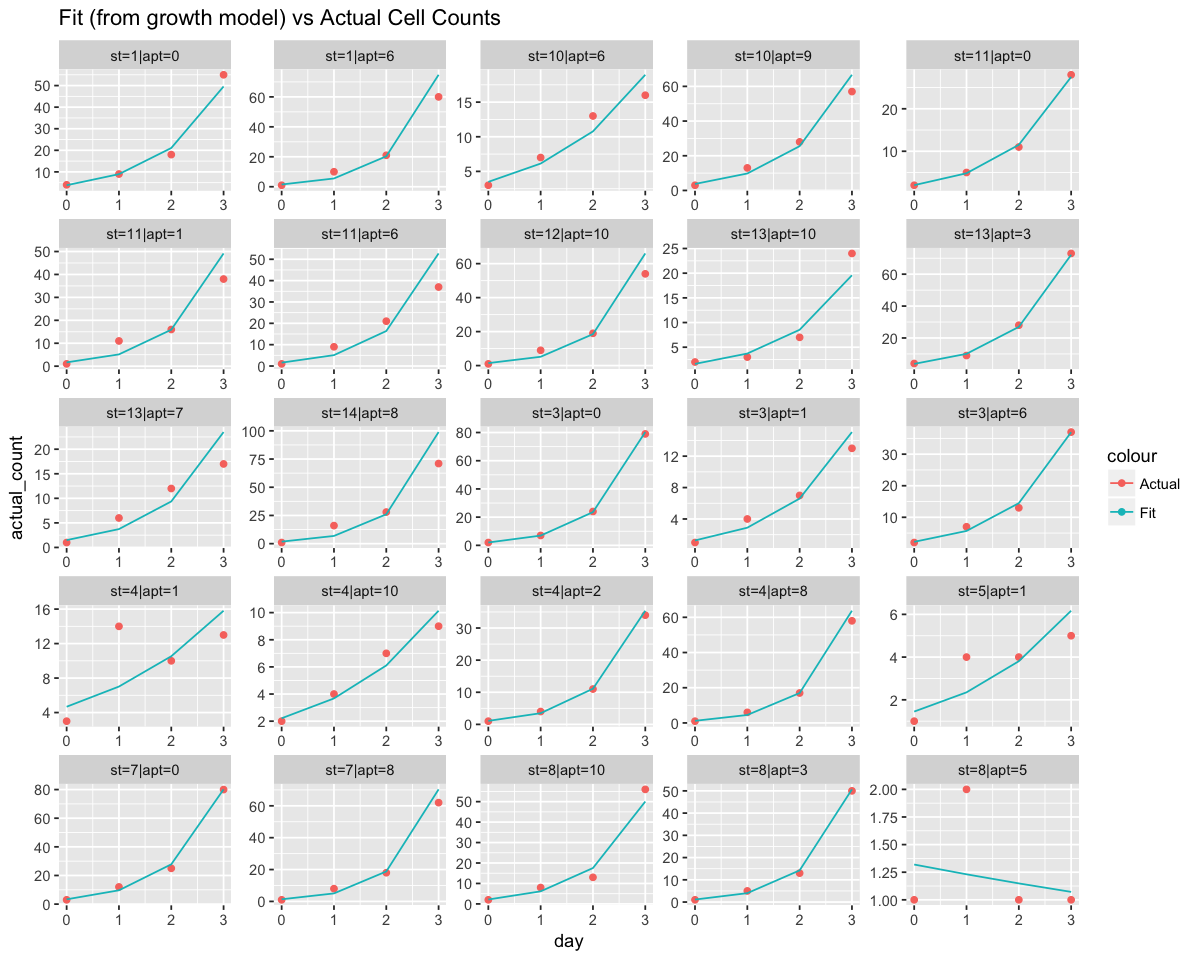

In [41]:
set.seed(1)

# Randomly sample 25 chips
sample.chips <- (df.res$chip_name %>% unique %>% base::sample(25))
stopifnot(length(sample.chips) == 25)

# View the actual cell counts vs fit counts from the individual models
options(repr.plot.width=10, repr.plot.height=8)
df.res %>% 
  filter(chip_name %in% sample.chips) %>%
  ggplot() + 
  geom_point(aes(x=day, y=actual_count, color='Actual')) +
  geom_line(aes(x=day, y=pred_count, color='Fit')) +
  facet_wrap(~chip_name, scales='free', ncol=5) +
  ggtitle('Fit (from growth model) vs Actual Cell Counts')

Summarize coefficients:

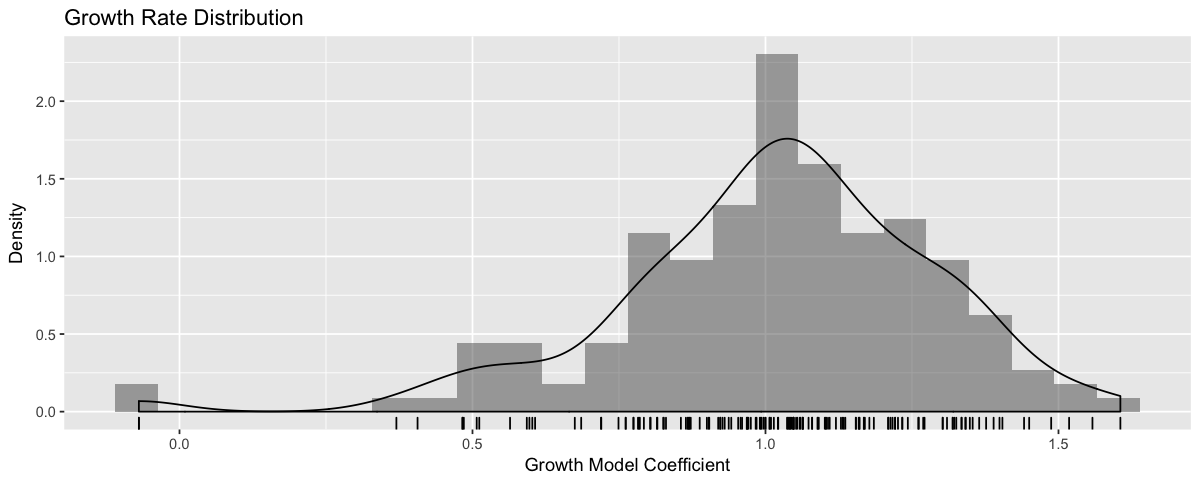

In [40]:
# Plot the distribution of the first order coefficients
options(repr.plot.width=10, repr.plot.height=4)
df.res %>% group_by(chip_name) %>% summarize(coef=max(coef)) %>% ungroup %>% 
  ggplot(aes(x=coef)) + 
  geom_histogram(aes(y=..density..), alpha=.5, bins=24) + 
  geom_density(aes(y=..density..)) +
  xlab('Growth Model Coefficient') +
  ylab('Density') +
  ggtitle('Growth Rate Distribution') +
  geom_rug()

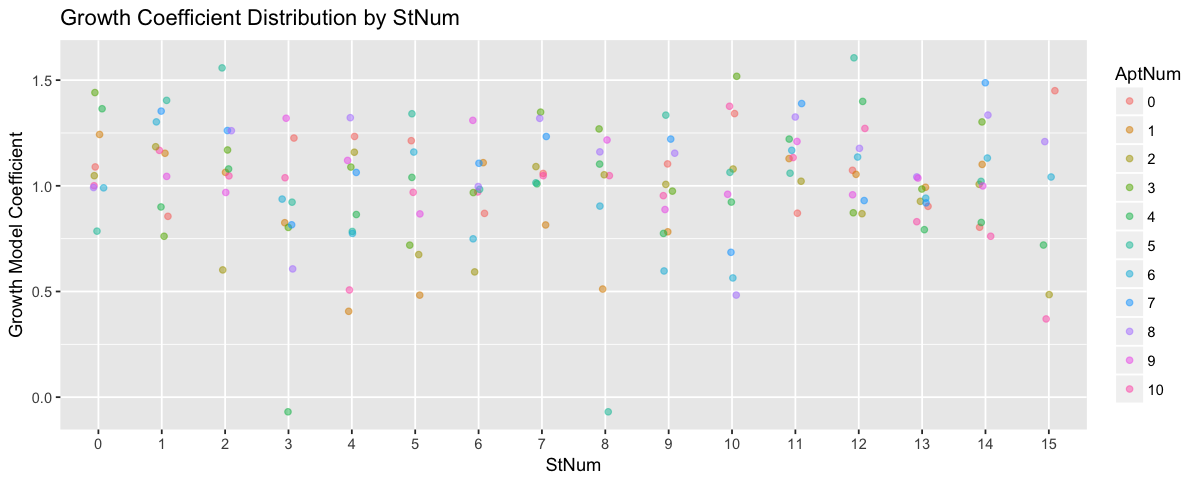

In [48]:
# Also check the distributions of coefficients by StNum to see if there are any interesting patterns there

options(repr.plot.width=10, repr.plot.height=4)
df.res %>% group_by(chip_name) %>% 
  summarize(coef=max(coef), stnum=max(stnum), aptnum=max(aptnum)) %>% ungroup %>% 
  ggplot(aes(x=as.factor(stnum), y=coef, color=as.factor(aptnum))) + 
  geom_jitter(alpha=.5, width=.1) +
  xlab('StNum') + ylab('Growth Model Coefficient') +
  ggtitle('Growth Coefficient Distribution by StNum') +
  scale_color_discrete(guide=guide_legend(title='AptNum')) 